# Old one

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
import cmath

class MicrowaveNetworkCalculator:
    def __init__(self, frequency_range: np.ndarray, z0: float = 50.0):
        """
        Initialize the microwave network calculator.
        
        Args:
            frequency_range: Array of frequencies in Hz at which to evaluate the network
            z0: Characteristic impedance of the system (default: 50 ohms)
        """
        self.frequency_range = frequency_range
        self.z0 = z0
        self.omega = 2 * np.pi * frequency_range
    
    def transmission_line_abcd(self, z_line: float, length: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a transmission line segment.
        
        Args:
            z_line: Characteristic impedance of the line in ohms
            length: Physical length of the line in meters
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # Calculate propagation constant (assuming lossless line)
        c = 3e7  # Speed of light in m/s
        beta = 2 * np.pi * freq / c
        
        # Calculate ABCD parameters
        A = np.cos(beta * length)
        B = 1j * z_line * np.sin(beta * length)
        C = 1j * np.sin(beta * length) / z_line
        D = np.cos(beta * length)
        
        return np.array([[A, B], [C, D]])
    
    def rlc_series_abcd(self, r: float, l: float, c: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a series RLC resonator.
        
        Args:
            r: Resistance in ohms
            l: Inductance in henries
            c: Capacitance in farads
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        # Calculate impedance of the series RLC
        if c == 0:  # Handle series RL case
            z = r + 1j * omega * l
        else:
            z = r + 1j * omega * l + 1 / (1j * omega * c)
        
        # ABCD matrix for series impedance
        A = 1
        B = z
        C = 0
        D = 1
        
        return np.array([[A, B], [C, D]])
    
    def rlc_parallel_abcd(self, r: float, l: float, c: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a parallel RLC resonator.
        
        Args:
            r: Resistance in ohms
            l: Inductance in henries
            c: Capacitance in farads
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        # Calculate admittance of the parallel RLC
        y_r = 1/r if r != 0 else 0
        y_l = 1/(1j * omega * l) if l != 0 else 0
        y_c = 1j * omega * c if c != 0 else 0
        
        y = y_r + y_l + y_c
        
        # ABCD matrix for parallel admittance
        A = 1
        B = 0
        C = y
        D = 1
        
        return np.array([[A, B], [C, D]])
    
    def magnon_element_abcd(self, omega_m: float, gamma: float, kappa: float, freq: float, Z0 = 50 ) -> np.array:
        """
        Calculate ABCD matrix for a magnon.
        
        Args:
            omega_m : resonance frequency
            gamma : disappative (intrinsic damping) rate 
            kappa : radiative(external) duamping rate
            
        
        Returns:
            2x2 ABCD matrix as numpy array
        """

        

        omega =  2 * np.pi*freq
        omega_m =2 * np.pi*  omega_m

        L = Z0 / (4*kappa)
        R = 2*L*gamma
        C = 1/(omega_m**2 *L)

        Z = R + 1j*omega*L + 1/(1j* omega*C)

        A = 1
        B = 0
        C = 1/Z
        D = 1

        return np.array([[A, B], [C, D]])



    def lumped_element_abcd(self, element_type: str, value: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for common lumped elements.
        
        Args:
            element_type: Type of element ('R', 'L', 'C', 'R_parallel', 'L_parallel', 'C_parallel')
            value: Element value (ohms for R, henries for L, farads for C)
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        if element_type == 'R':
            # Series resistor
            return np.array([[1, value], [0, 1]])
        elif element_type == 'L':
            # Series inductor
            return np.array([[1, 1j * omega * value], [0, 1]])
        elif element_type == 'C':
            # Series capacitor
            return np.array([[1, 1 / (1j * omega * value)], [0, 1]])
        elif element_type == 'R_parallel':
            # Parallel resistor
            return np.array([[1, 0], [1 / value, 1]])
        elif element_type == 'L_parallel':
            # Parallel inductor
            return np.array([[1, 0], [1 / (1j * omega * value), 1]])
        elif element_type == 'C_parallel':
            # Parallel capacitor
            return np.array([[1, 0], [1j * omega * value, 1]])
        else:
            raise ValueError(f"Unknown element type: {element_type}")
    
    def cascade_abcd(self, abcd_matrices: List[np.ndarray]) -> np.ndarray:
        """
        Calculate the overall ABCD matrix for a cascade of networks.
        
        Args:
            abcd_matrices: List of ABCD matrices
        
        Returns:
            Combined 2x2 ABCD matrix as numpy array
        """
        result = np.identity(2)
        for matrix in abcd_matrices:
            result = np.matmul(result, matrix)
        return result
    
    def abcd_to_s_parameters(self, abcd: np.ndarray, z0: float = None) -> np.ndarray:
        """
        Convert ABCD matrix to S-parameters.
        
        Args:
            abcd: 2x2 ABCD matrix
            z0: Characteristic impedance (uses self.z0 if None)
        
        Returns:
            2x2 S-parameter matrix as numpy array
        """
        if z0 is None:
            z0 = self.z0
        
        A, B, C, D = abcd[0, 0], abcd[0, 1], abcd[1, 0], abcd[1, 1]
        
        denominator = A + B/z0 + C*z0 + D
        
        S11 = (A + B/z0 - C*z0 - D) / denominator
        S12 = 2 * (A*D - B*C) / denominator
        S21 = 2 / denominator
        S22 = (-A + B/z0 - C*z0 + D) / denominator
        
        return np.array([[S11, S12], [S21, S22]])
    
    def short_circuit_abcd(self) -> np.ndarray:
        """
        Calculate ABCD matrix for a short circuit (ground) termination.
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # For a short circuit termination, Z=0
        # This is equivalent to a shunt with Z=0, or Y→∞
        # Mathematically, the ABCD matrix would have B=0, C=∞
        # But we can't directly represent infinity in our calculations
        # Instead, we'll use a very small resistance as an approximation
        very_small_r = 1e-10
        
        # ABCD matrix for a shunt with very small resistance
        return np.array([[1, 0], [1/very_small_r, 1]])
    
    def open_circuit_abcd(self) -> np.ndarray:
        """
        Calculate ABCD matrix for an open circuit termination.
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # For an open circuit termination, Z=∞
        # This is equivalent to a shunt with Z=∞, or Y=0
        # The ABCD matrix is:
        return np.array([[1, 0], [0, 1]])
    
    def calculate_network(self, network_elements: List[Dict], termination: str = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculate S-parameters for a network over the frequency range.
        
        Args:
            network_elements: List of dictionaries describing each element
                Each dict should have:
                    'type': 'tline' | 'series_rlc' | 'parallel_rlc' | 'lumped'
                    Plus type-specific parameters:
                        For 'tline': 'z0', 'length'
                        For 'series_rlc': 'r', 'l', 'c'
                        For 'parallel_rlc': 'r', 'l', 'c'
                        For 'lumped': 'element_type', 'value'
            termination: Optional termination type ('short', 'open', or None for matched load)
        
        Returns:
            Tuple of (frequencies, S-parameter matrices)
        """
        s_matrices = []
        
        for freq in self.frequency_range:
            abcd_matrices = []
            
            for element in network_elements:
                element_type = element['type']
                
                if element_type == 'tline':
                    abcd = self.transmission_line_abcd(
                        element['z0'], element['length'], freq
                    )
                elif element_type == 'series_rlc':
                    abcd = self.rlc_series_abcd(
                        element.get('r', 0), element.get('l', 0), element.get('c', 0), freq
                    )
                elif element_type == 'parallel_rlc':
                    abcd = self.rlc_parallel_abcd(
                        element.get('r', 0), element.get('l', 0), element.get('c', 0), freq
                    )
                elif element_type == 'lumped':
                    abcd = self.lumped_element_abcd(
                        element['element_type'], element['value'], freq
                    )
                elif element_type == 'magnon':
                    abcd = self.magnon_element_abcd(
                        element.get('omega_m', 0), element.get('gamma', 0), element.get('kappa', 0), freq
                    )
                else:
                    raise ValueError(f"Unknown element type: {element_type}")
                
                abcd_matrices.append(abcd)
            
            # Calculate overall ABCD matrix
            total_abcd = self.cascade_abcd(abcd_matrices)
            
            # Add termination if specified
            if termination == 'short':
                short_abcd = self.short_circuit_abcd()
                total_abcd = np.matmul(total_abcd, short_abcd)
            elif termination == 'open':
                open_abcd = self.open_circuit_abcd()
                total_abcd = np.matmul(total_abcd, open_abcd)
            
            # Convert to S-parameters
            s_matrix = self.abcd_to_s_parameters(total_abcd)
            s_matrices.append(s_matrix)
        
        return self.frequency_range, np.array(s_matrices)

    def plot_s_parameters(self, s_params: np.ndarray, param_names: List[str] = None, 
                          plot_magnitude: bool = True, plot_phase: bool = True,
                          db_scale: bool = True):
        """
        Plot S-parameters vs frequency.
        
        Args:
            s_params: Array of S-parameter matrices
            param_names: List of S-parameter names to plot (e.g., ['S11', 'S21'])
            plot_magnitude: Whether to plot magnitude
            plot_phase: Whether to plot phase
            db_scale: Whether to use dB scale for magnitude
        """
        if param_names is None:
            param_names = ['S11', 'S21', 'S12', 'S22']
        
        indices = {
            'S11': (0, 0),
            'S12': (0, 1),
            'S21': (1, 0),
            'S22': (1, 1)
        }
        
        freq_ghz = self.frequency_range / 1e9  # Convert to GHz for plotting
        
        plt.figure(figsize=(6, 4))
        
        # Plot magnitude
        if plot_magnitude:
            plt.subplot(2 if plot_phase else 1, 1, 1)
            for name in param_names:
                i, j = indices[name]
                magnitude = np.abs([s[i, j] for s in s_params])
                
                if db_scale:
                    magnitude_db = 20 * np.log10(magnitude)
                    plt.plot(freq_ghz, magnitude_db, label=f"|{name}| (dB)")
                    plt.ylabel('Magnitude (dB)')
                else:
                    plt.plot(freq_ghz, magnitude, label=f"|{name}|")
                    plt.ylabel('Magnitude')
            
            plt.grid(True)
            plt.legend()
            plt.title('S-Parameter Magnitude')
            plt.xlabel('Frequency (GHz)')
        
        # Plot phase
        if plot_phase:
            plt.subplot(2, 1, 2 if plot_magnitude else 1)
            for name in param_names:
                i, j = indices[name]
                phase_deg = np.angle([s[i, j] for s in s_params]) * 180 / np.pi
                plt.plot(freq_ghz, phase_deg, label=f"∠{name} (deg)")
            
            plt.grid(True)
            plt.legend()
            plt.title('S-Parameter Phase')
            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Phase (degrees)')
        
        plt.tight_layout()
        plt.show()




# plot 測試

{'z_line': <class 'float'>, 'length': <class 'float'>, 'freq': <class 'float'>, 'return': <class 'numpy.ndarray'>}
{'omega_m': <class 'float'>, 'gamma': <class 'float'>, 'kappa': <class 'float'>, 'freq': <class 'float'>, 'return': <built-in function array>}
{'r': <class 'float'>, 'l': <class 'float'>, 'c': <class 'float'>, 'freq': <class 'float'>, 'return': <class 'numpy.ndarray'>}
Matched Termination (50Ω)


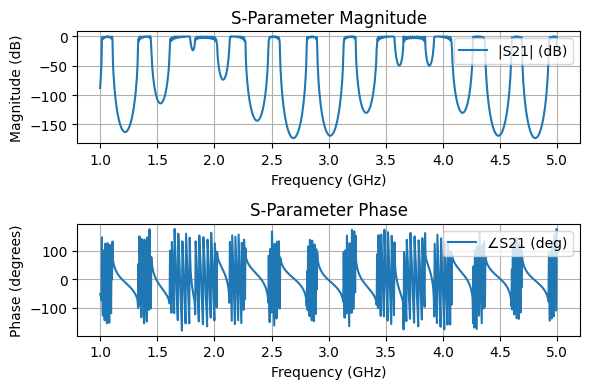

Open Circuit Termination


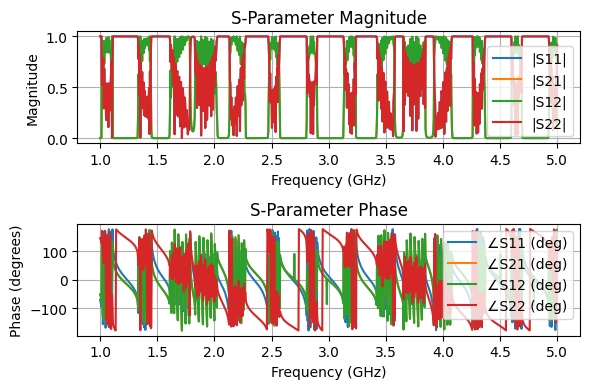

<Figure size 640x480 with 0 Axes>

S-parameters at 2 GHz with matched termination:
S11: 0.346431528837395
S21: 0.9380749395362128
S12: 0.9380749395362128
S22: 0.346430914207165

S-parameters at 2 GHz with SHORT termination:

S-parameters at 2 GHz with OPEN termination:
S11: (-0.08400411944539013+0.3360924159942016j)


In [23]:
# Example usage
from typing import Union


if __name__ == "__main__":
    # Define frequency range
    f_start = 1e9  # 1 GHz
    f_stop = 5e9   # 3 GHz
    f_points = 1001
    frequencies = np.linspace(f_start, f_stop, f_points)
    
    # Initialize calculator
    calculator = MicrowaveNetworkCalculator(frequencies)
    
    # Example network: Transmission line -> Series RLC resonator -> Transmission line
    # transmission : tline, z0(Ohm), length(m)
    # magnon : omega_m(Hz), gamma(Hz) 
    print(MicrowaveNetworkCalculator.transmission_line_abcd.__annotations__)
    print(MicrowaveNetworkCalculator.magnon_element_abcd.__annotations__)
    print(MicrowaveNetworkCalculator.rlc_parallel_abcd.__annotations__)

    network = [
        
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},  # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},  # 1cm transmission line
        {'type': 'magnon', 'omega_m': 5e9, 'gamma': 0.1e7, 'kappa': 2e7},  # Series RLC
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},  # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
        {'type': 'tline', 'z0': 125, 'length': 0.042},   # 2cm transmission line
        {'type': 'tline', 'z0': 28, 'length': 0.008},
    ]
    
    # Calculate S-parameters with different terminations
    freq, s_params_matched = calculator.calculate_network(network)  # Default: matched termination
    # freq, s_params_short = calculator.calculate_network(network, termination='short')  # Short circuit termination
    freq, s_params_open = calculator.calculate_network(network, termination='open')    # Open circuit termination
    
    # Plot results for matched termination
    
    
    #plt.subplot(3, 1, 1)
    print('Matched Termination (50Ω)')
    calculator.plot_s_parameters(s_params_matched, param_names=['S21'], db_scale= True)
    
    
    # # Plot results for short circuit termination
    # #plt.subplot(3, 1, 2)
    # print('Short Circuit Termination')
    # calculator.plot_s_parameters(s_params_short, param_names=['S11', 'S21','S12', 'S22'], db_scale= None)
    
    # Plot results for open circuit termination
    #plt.subplot(3, 1, 3)
    print('Open Circuit Termination')
    calculator.plot_s_parameters(s_params_open, param_names=['S11', 'S21','S12', 'S22'], db_scale= None)
    
    #plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Print specific values at 2 GHz for matched termination
    index_2ghz = np.abs(freq - 4e9).argmin()
    print(f"S-parameters at 2 GHz with matched termination:")
    print(f"S11: {abs(s_params_matched[index_2ghz][0, 0])}")
    print(f"S21: {abs(s_params_matched[index_2ghz][1, 0])}")
    print(f"S12: {abs(s_params_matched[index_2ghz][0, 1])}")
    print(f"S22: {abs(s_params_matched[index_2ghz][1, 1])}")
    
    print(f"\nS-parameters at 2 GHz with SHORT termination:")
    #print(f"S11: {s_params_short[index_2ghz][0, 0]}")
    
    print(f"\nS-parameters at 2 GHz with OPEN termination:")
    print(f"S11: {s_params_open[index_2ghz][0, 0]}")

# New type

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
import cmath

class MicrowaveNetworkCalculator:
    def __init__(self, frequency_range: np.ndarray, z0: float = 50.0):
        """
        Initialize the microwave network calculator.
        
        Args:
            frequency_range: Array of frequencies in Hz at which to evaluate the network
            z0: Characteristic impedance of the system (default: 50 ohms)
        """
        self.frequency_range = frequency_range
        self.z0 = z0
        self.omega = 2 * np.pi * frequency_range
    
    def transmission_line_abcd(self, z_line: float, length: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a transmission line segment.
        
        Args:
            z_line: Characteristic impedance of the line in ohms
            length: Physical length of the line in meters
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # Calculate propagation constant (assuming lossless line)
        c = 3e7  # Speed of light in m/s
        beta = 2 * np.pi * freq / c
        
        # Calculate ABCD parameters
        A = np.cos(beta * length)
        B = 1j * z_line * np.sin(beta * length)
        C = 1j * np.sin(beta * length) / z_line
        D = np.cos(beta * length)
        
        return np.array([[A, B], [C, D]])
    
    def rlc_series_abcd(self, r: float, l: float, c: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a series RLC resonator.
        
        Args:
            r: Resistance in ohms
            l: Inductance in henries
            c: Capacitance in farads
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        # Calculate impedance of the series RLC
        if c == 0:  # Handle series RL case
            z = r + 1j * omega * l
        else:
            z = r + 1j * omega * l + 1 / (1j * omega * c)
        
        # ABCD matrix for series impedance
        A = 1
        B = z
        C = 0
        D = 1
        
        return np.array([[A, B], [C, D]])
    
    def rlc_parallel_abcd(self, r: float, l: float, c: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for a parallel RLC resonator.
        
        Args:
            r: Resistance in ohms
            l: Inductance in henries
            c: Capacitance in farads
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        # Calculate admittance of the parallel RLC
        y_r = 1/r if r != 0 else 0
        y_l = 1/(1j * omega * l) if l != 0 else 0
        y_c = 1j * omega * c if c != 0 else 0
        
        y = y_r + y_l + y_c
        
        # ABCD matrix for parallel admittance
        A = 1
        B = 0
        C = y
        D = 1
        
        return np.array([[A, B], [C, D]])
    
    def lumped_element_abcd(self, element_type: str, value: float, freq: float) -> np.ndarray:
        """
        Calculate ABCD matrix for common lumped elements.
        
        Args:
            element_type: Type of element ('R', 'L', 'C', 'R_parallel', 'L_parallel', 'C_parallel')
            value: Element value (ohms for R, henries for L, farads for C)
            freq: Frequency in Hz
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        
        if element_type == 'R':
            # Series resistor
            return np.array([[1, value], [0, 1]])
        elif element_type == 'L':
            # Series inductor
            return np.array([[1, 1j * omega * value], [0, 1]])
        elif element_type == 'C':
            # Series capacitor
            return np.array([[1, 1 / (1j * omega * value)], [0, 1]])
        elif element_type == 'R_parallel':
            # Parallel resistor
            return np.array([[1, 0], [1 / value, 1]])
        elif element_type == 'L_parallel':
            # Parallel inductor
            return np.array([[1, 0], [1 / (1j * omega * value), 1]])
        elif element_type == 'C_parallel':
            # Parallel capacitor
            return np.array([[1, 0], [1j * omega * value, 1]])
        else:
            raise ValueError(f"Unknown element type: {element_type}")
    
    def cascade_abcd(self, abcd_matrices: List[np.ndarray]) -> np.ndarray:
        """
        Calculate the overall ABCD matrix for a cascade of networks.
        
        Args:
            abcd_matrices: List of ABCD matrices
        
        Returns:
            Combined 2x2 ABCD matrix as numpy array
        """
        result = np.identity(2)
        for matrix in abcd_matrices:
            result = np.matmul(result, matrix)
        return result
    
    def abcd_to_s_parameters(self, abcd: np.ndarray, z0: float = None) -> np.ndarray:
        """
        Convert ABCD matrix to S-parameters.
        
        Args:
            abcd: 2x2 ABCD matrix
            z0: Characteristic impedance (uses self.z0 if None)
        
        Returns:
            2x2 S-parameter matrix as numpy array
        """
        if z0 is None:
            z0 = self.z0
        
        A, B, C, D = abcd[0, 0], abcd[0, 1], abcd[1, 0], abcd[1, 1]
        
        denominator = A + B/z0 + C*z0 + D
        
        S11 = (A + B/z0 - C*z0 - D) / denominator
        S12 = 2 * (A*D - B*C) / denominator
        S21 = 2 / denominator
        S22 = (-A + B/z0 - C*z0 + D) / denominator
        
        return np.array([[S11, S12], [S21, S22]])
    
    def short_circuit_abcd(self) -> np.ndarray:
        """
        Calculate ABCD matrix for a short circuit (ground) termination.
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # For a short circuit termination, Z=0
        # This is equivalent to a shunt with Z=0, or Y→∞
        # Mathematically, the ABCD matrix would have B=0, C=∞
        # But we can't directly represent infinity in our calculations
        # Instead, we'll use a very small resistance as an approximation
        very_small_r = 1e-10
        
        # ABCD matrix for a shunt with very small resistance
        return np.array([[1, 0], [1/very_small_r, 1]])
    
    def open_circuit_abcd(self) -> np.ndarray:
        """
        Calculate ABCD matrix for an open circuit termination.
        
        Returns:
            2x2 ABCD matrix as numpy array
        """
        # For an open circuit termination, Z=∞
        # This is equivalent to a shunt with Z=∞, or Y=0
        # The ABCD matrix is:
        return np.array([[1, 0], [0, 1]])
    
    def magnon_abcd(self, omega_m: float, gamma: float, kappa: float, freq: float, z0: float = 50.0) -> np.ndarray:
        """
        Calculate ABCD matrix for a magnon resonator.
        
        Args:
            omega_m: Magnon resonance frequency in Hz
            gamma: Damping rate in Hz
            kappa: Coupling rate in Hz
            freq: Frequency in Hz at which to calculate the ABCD matrix
            z0: Characteristic impedance (default: 50 ohms)
            
        Returns:
            2x2 ABCD matrix as numpy array
        """
        omega = 2 * np.pi * freq
        omega_m = 2 * np.pi * omega_m
        
        # Calculate equivalent RLC parameters
        L = z0 / (4 * kappa)
        R = 2 * L * gamma
        C = 1 / (omega_m**2 * L)
        
        # Calculate impedance
        Z = R + 1j * omega * L + 1 / (1j * omega * C)
        
        # Calculate ABCD parameters for a shunt element
        A = 1
        B = 0
        C = 1 / Z
        D = 1
        
        return np.array([[A, B], [C, D]])
    
    def calculate_network(self, network_elements: List[Dict], termination: str = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculate S-parameters for a network over the frequency range.
        
        Args:
            network_elements: List of dictionaries describing each element
                Each dict should have:
                    'type': 'tline' | 'series_rlc' | 'parallel_rlc' | 'lumped' | 'magnon'
                    Plus type-specific parameters:
                        For 'tline': 'z0', 'length'
                        For 'series_rlc': 'r', 'l', 'c'
                        For 'parallel_rlc': 'r', 'l', 'c'
                        For 'lumped': 'element_type', 'value'
                        For 'magnon': 'omega_m', 'gamma', 'kappa'
            termination: Optional termination type ('short', 'open', or None for matched load)
        
        Returns:
            Tuple of (frequencies, S-parameter matrices)
        """
        s_matrices = []
        
        for freq in self.frequency_range:
            abcd_matrices = []
            
            for element in network_elements:
                element_type = element['type']
                
                if element_type == 'tline':
                    abcd = self.transmission_line_abcd(
                        element['z0'], element['length'], freq
                    )
                elif element_type == 'series_rlc':
                    abcd = self.rlc_series_abcd(
                        element.get('r', 0), element.get('l', 0), element.get('c', 0), freq
                    )
                elif element_type == 'parallel_rlc':
                    abcd = self.rlc_parallel_abcd(
                        element.get('r', 0), element.get('l', 0), element.get('c', 0), freq
                    )
                elif element_type == 'lumped':
                    abcd = self.lumped_element_abcd(
                        element['element_type'], element['value'], freq
                    )
                elif element_type == 'magnon':
                    abcd = self.magnon_abcd(
                        element['omega_m'], element['gamma'], element['kappa'], freq, 
                        element.get('z0', self.z0)
                    )
                else:
                    raise ValueError(f"Unknown element type: {element_type}")
                
                abcd_matrices.append(abcd)
            
            # Calculate overall ABCD matrix
            total_abcd = self.cascade_abcd(abcd_matrices)
            
            # Add termination if specified
            if termination == 'short':
                short_abcd = self.short_circuit_abcd()
                total_abcd = np.matmul(total_abcd, short_abcd)
            elif termination == 'open':
                open_abcd = self.open_circuit_abcd()
                total_abcd = np.matmul(total_abcd, open_abcd)
            
            # Convert to S-parameters
            s_matrix = self.abcd_to_s_parameters(total_abcd)
            s_matrices.append(s_matrix)
        
        return self.frequency_range, np.array(s_matrices)

    def plot_s_parameters(self, s_params: np.ndarray, param_names: List[str] = None, 
                          plot_magnitude: bool = True, plot_phase: bool = True,
                          db_scale: bool = True):
        """
        Plot S-parameters vs frequency.
        
        Args:
            s_params: Array of S-parameter matrices
            param_names: List of S-parameter names to plot (e.g., ['S11', 'S21'])
            plot_magnitude: Whether to plot magnitude
            plot_phase: Whether to plot phase
            db_scale: Whether to use dB scale for magnitude
        """
        if param_names is None:
            param_names = ['S11', 'S21', 'S12', 'S22']
        
        indices = {
            'S11': (0, 0),
            'S12': (0, 1),
            'S21': (1, 0),
            'S22': (1, 1)
        }
        
        freq_ghz = self.frequency_range / 1e9  # Convert to GHz for plotting
        
        plt.figure(figsize=(6, 4))
        
        # Plot magnitude
        if plot_magnitude:
            plt.subplot(2 if plot_phase else 1, 1, 1)
            for name in param_names:
                i, j = indices[name]
                magnitude = np.abs([s[i, j] for s in s_params])
                
                if db_scale:
                    magnitude_db = 20 * np.log10(magnitude)
                    plt.plot(freq_ghz, magnitude_db, label=f"|{name}| (dB)")
                    plt.ylabel('Magnitude (dB)')
                else:
                    plt.plot(freq_ghz, magnitude, label=f"|{name}|")
                    plt.ylabel('Magnitude')
            
            plt.grid(True)
            plt.legend()
            plt.title('S-Parameter Magnitude')
            plt.xlabel('Frequency (GHz)')
        
        # Plot phase
        if plot_phase:
            plt.subplot(2, 1, 2 if plot_magnitude else 1)
            for name in param_names:
                i, j = indices[name]
                phase_deg = np.angle([s[i, j] for s in s_params]) * 180 / np.pi
                plt.plot(freq_ghz, phase_deg, label=f"∠{name} (deg)")
            
            plt.grid(True)
            plt.legend()
            plt.title('S-Parameter Phase')
            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Phase (degrees)')
        
        plt.tight_layout()
        plt.show()




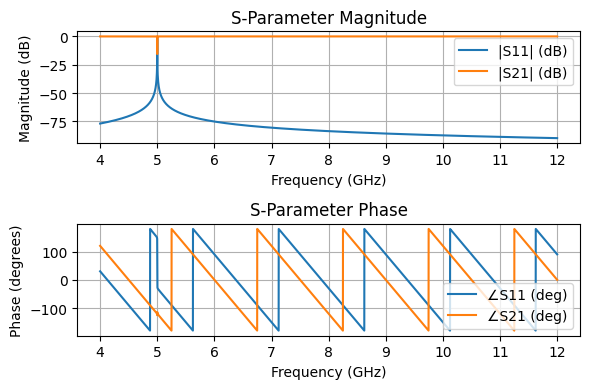

Magnon Resonator Network
S-parameters at 2 GHz with matched termination:
S11: (0.0023199192685920775+0.0013147739791845145j)
S21: (-0.5022985873005072-0.8646736817526997j)
S12: (-0.5022985873005072-0.8646736817526997j)
S22: (-2.133196808730206e-05-0.0026664960109219803j)

S-parameters at 2 GHz with SHORT termination:
S11: (0.49999999999799466-0.8660254037809777j)

S-parameters at 2 GHz with OPEN termination:
S11: (0.0023199192685920775+0.0013147739791845145j)

S-parameters at 2 GHz with MAGNON network:
S11: (0.00012252953722119992+7.071472900273614e-05j)
S21: (-0.49987747046277725+0.8660961185134423j)


In [153]:
# Example usage
if __name__ == "__main__":
    # Define frequency range
    f_start = 4e9  # 1 GHz
    f_stop = 12e9   # 3 GHz
    f_points = 5001
    frequencies = np.linspace(f_start, f_stop, f_points)
    
    # Initialize calculator
    calculator = MicrowaveNetworkCalculator(frequencies)
    
    # Example network: Transmission line -> Series RLC resonator -> Transmission line
    network = [
        {'type': 'tline', 'z0': 50, 'length': 0.01},  # 1cm transmission line
        {'type': 'series_rlc', 'r': 1, 'l': 1e-9, 'c': 2.5e-12},  # Series RLC
        {'type': 'tline', 'z0': 75, 'length': 0.02}   # 2cm transmission line
    ]
    
    # Example network with magnon
    magnon_network = [
        {'type': 'tline', 'z0': 50, 'length': 0.01},  # 1cm transmission line
        {'type': 'magnon', 'omega_m': 5e9, 'gamma': 0.2e6, 'kappa': 1e6},  # Magnon resonator at 2 GHz
        {'type': 'tline', 'z0': 50, 'length': 0.01}   # 1cm transmission line
    ]
    
    # # Calculate S-parameters with different terminations
    # freq, s_params_matched = calculator.calculate_network(network)  # Default: matched termination
    # freq, s_params_short = calculator.calculate_network(network, termination='short')  # Short circuit termination
    # freq, s_params_open = calculator.calculate_network(network, termination='open')    # Open circuit termination
    # 
    # Calculate S-parameters for magnon network
    freq, s_params_magnon = calculator.calculate_network(magnon_network)
    # 
    # # Plot results for matched termination
     # plt.figure(figsize=(15, 12))
    # print('Network with Different Terminations')
    # 
    # # plt.subplot(4, 1, 1)
    # calculator.plot_s_parameters(s_params_matched, param_names=['S11', 'S21'])
    # print('Matched Termination (50Ω)')
    # 
    # # Plot results for short circuit termination
    # # plt.subplot(4, 1, 2)
    # calculator.plot_s_parameters(s_params_short, param_names=['S11', 'S21'])
    # print('Short Circuit Termination')
    # 
    # # Plot results for open circuit termination
    # # plt.subplot(4, 1, 3)
    # calculator.plot_s_parameters(s_params_open, param_names=['S11', 'S21'])
    # print('Open Circuit Termination')
    
    # Plot results for magnon network
    # plt.subplot(4, 1, 4)
    calculator.plot_s_parameters(s_params_magnon, param_names=['S11', 'S21'])
    print('Magnon Resonator Network')
    
    # plt.tight_layout()
    # plt.subplots_adjust(top=0.9)
    # plt.show()
    
    # Print specific values at 2 GHz for matched termination
    index_2ghz = np.abs(freq - 2e9).argmin()
    print(f"S-parameters at 2 GHz with matched termination:")
    print(f"S11: {s_params_matched[index_2ghz][0, 0]}")
    print(f"S21: {s_params_matched[index_2ghz][1, 0]}")
    print(f"S12: {s_params_matched[index_2ghz][0, 1]}")
    print(f"S22: {s_params_matched[index_2ghz][1, 1]}")
    
    print(f"\nS-parameters at 2 GHz with SHORT termination:")
    print(f"S11: {s_params_short[index_2ghz][0, 0]}")
    
    print(f"\nS-parameters at 2 GHz with OPEN termination:")
    print(f"S11: {s_params_open[index_2ghz][0, 0]}")
    
    print(f"\nS-parameters at 2 GHz with MAGNON network:")
    print(f"S11: {s_params_magnon[index_2ghz][0, 0]}")
    print(f"S21: {s_params_magnon[index_2ghz][1, 0]}")